In [1]:
import mitsuba as mi 
from matplotlib import pyplot as plt
mi.set_variant("cuda_ad_rgb")
import drjit as dr
from PDE3D.BoundaryShape import *
from PDE3D import PATH
from PDE3D.utils import *
from PDE3D.Solver import *


In [2]:
vis_conf = 0
resolution = [256,256]
spp = 512
radius = 1
slice_offset = .2
slice_axis = "z"
boundary_value = 0
majorant = 100
def source_generator(points, params):
    return dr.select(dr.norm(points) < params["radius"], params["power"], 0) + 1 + 10 * points[0]
source_p = {}
source_p["radius"] = 0.5
source_p["power"] = 1
f = FunctionCoefficient("source", source_p, source_generator)
σ = ConstantCoefficient("screening", 10)
b = ConstantCoefficient("dirichlet", boundary_value)

In [3]:
shape = Sphere(radius = radius, dirichlet = [b])
data_holder = DataHolder(shape = shape, f=f, σ=σ, default_majorant=majorant)

In [4]:
wos_c = WosConstant(data_holder)
wos_v = WosVariable(data_holder)
slice = Slice(offset = slice_offset, axis = slice_axis)

points, film_points = slice.create_slice_points(resolution, spp)
L_c, p = wos_c.solve(points_in= points, conf_numbers= [mi.UInt32(0), mi.UInt32(1)])
L_v, p = wos_v.solve(points_in= points, conf_numbers= [mi.UInt32(0), mi.UInt32(1)])

0 : 33554432 -> 0


In [5]:
image_c, _ =create_slice_from_result(L_c, resolution)
image_v, _ =create_slice_from_result(L_v, resolution)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004874..1.5726548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.004874..1.5726548].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.01555616..1.5726548].


Text(0.5, 1.0, 'Difference')

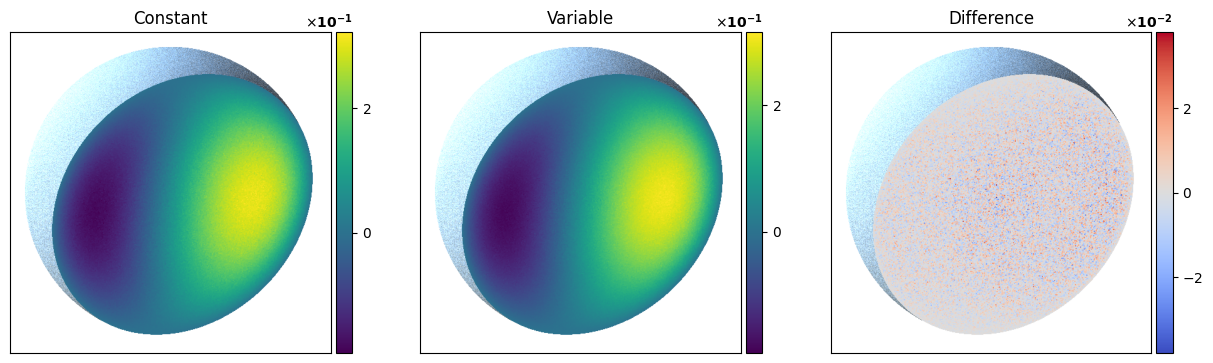

In [6]:
cmap= "viridis"
cam_origin = mi.Point3f([-1.0,1.0,2])
image_v_3D, norm1 = shape.visualize(slice = slice, slice_image = mi.TensorXf(image_v[vis_conf]), colormap = cmap, cam_origin= cam_origin, image_res=[512, 512])
image_c_3D, norm2 = shape.visualize(slice = slice, slice_image = mi.TensorXf(image_c[vis_conf]), colormap = cmap, cam_origin= cam_origin, image_res=[512, 512])
image3D_diff, norm_diff = shape.visualize(slice = slice, slice_image = mi.TensorXf(image_v[vis_conf] - image_c[vis_conf]), colormap = "coolwarm", 
                                          cam_origin= cam_origin, image_res=[512, 512], sym_colorbar=True)
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (15,5))
plot_image_3D(image_v_3D, ax1, norm = norm1, cmap = cmap)
plot_image_3D(image_c_3D, ax2, norm = norm2, cmap = cmap)
plot_image_3D(image3D_diff, ax3, norm = norm_diff, cmap = "coolwarm")
ax1.set_title("Constant")
ax2.set_title("Variable")
ax3.set_title("Difference")
